In [1]:
import os

def explore_dataset(root_dir):
    # Dictionary to hold the number of files in each category
    category_summary = {}

    # Walk through the directory
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            num_files = 0
            for root, _, files in os.walk(category_path):
                num_files += len([file for file in files if file.endswith(".jpg")])
            category_summary[category] = num_files

    # Print out the summary of each category
    for category, count in category_summary.items():
        print(f"Category: {category} - Number of Images: {count}")

# Path to your dataset
root_dir = "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/"

# Explore the dataset
explore_dataset(root_dir)


Category: attack_cce - Number of Images: 28800
Category: attack_hp - Number of Images: 28800
Category: attack_print1 - Number of Images: 28800
Category: attack_print2 - Number of Images: 28800
Category: real - Number of Images: 28800


Train set size: 46080
Validation set size: 11520
Test set size: 57600


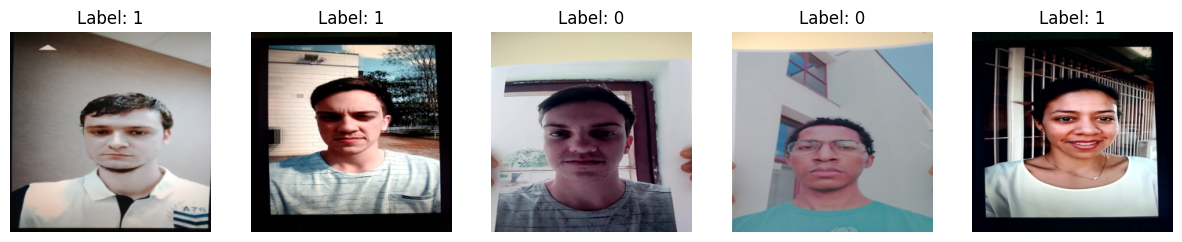

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms
import matplotlib.image as mpimg
import torch.nn as nn
import torch.optim as optim

# Define the custom dataset class
class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label
        
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.data.append(os.path.join(root, file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = mpimg.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the datasets
root_dir = "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/"
attack_print1_dataset = SpoofDataset(root_dir=root_dir, category="attack_print1", label=0, transform=transform)
attack_hp_dataset = SpoofDataset(root_dir=root_dir, category="attack_hp", label=1, transform=transform)

# Combine the datasets for training and validation
combined_train_dataset = ConcatDataset([attack_print1_dataset, attack_hp_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size

train_dataset, val_dataset = random_split(combined_train_dataset, [train_size, val_size])

# Load the "attack_print2" and "attack_cce" datasets for testing
test_print2_dataset = SpoofDataset(root_dir=root_dir, category="attack_print2", label=0, transform=transform)
test_cce_dataset = SpoofDataset(root_dir=root_dir, category="attack_cce", label=1, transform=transform)

# Combine the test datasets
combined_test_dataset = ConcatDataset([test_print2_dataset, test_cce_dataset])

# Create DataLoaders for train, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

# Print out sizes for confirmation
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Function to show a few images with their labels
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {label.item()}")
        axes[idx].axis('off')
    plt.show()

# Show a few images from the training set
show_images(train_loader)


In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from einops import rearrange
import math
import warnings
from torch.nn.init import _calculate_fan_in_and_fan_out

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def variance_scaling_(tensor, scale=1.0, mode='fan_in', distribution='normal'):
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    if mode == 'fan_in':
        denom = fan_in
    elif mode == 'fan_out':
        denom = fan_out
    elif mode == 'fan_avg':
        denom = (fan_in + fan_out) / 2
    variance = scale / denom
    if distribution == "truncated_normal":
        trunc_normal_(tensor, std=math.sqrt(variance) / .87962566103423978)
    elif distribution == "normal":
        tensor.normal_(std=math.sqrt(variance))
    elif distribution == "uniform":
        bound = math.sqrt(3 * variance)
        tensor.uniform_(-bound, bound)
    else:
        raise ValueError(f"invalid distribution {distribution}")


def lecun_normal_(tensor):
    variance_scaling_(tensor, mode='fan_in', distribution='truncated_normal')


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)


class GELU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

def conv(in_channels, out_channels, kernel_size, bias=False, padding = 1, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride=stride)


def shift_back(inputs,step=2):          # input [bs,28,256,310]  output [bs, 28, 256, 256]
    [bs, nC, row, col] = inputs.shape
    down_sample = 256//row
    step = float(step)/float(down_sample*down_sample)
    out_col = row
    for i in range(nC):
        inputs[:,i,:,:out_col] = \
            inputs[:,i,:,int(step*i):int(step*i)+out_col]
    return inputs[:, :, :, :out_col]

# class MS_MSA(nn.Module):
#     def __init__(
#             self,
#             dim,
#             dim_head,
#             heads,
#     ):
#         super().__init__()
#         self.num_heads = heads
#         self.dim_head = dim_head
#         self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
#         self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
#         self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
#         self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
#         self.proj = nn.Linear(dim_head * heads, dim, bias=True)
#         self.pos_emb = nn.Sequential(
#             nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
#             GELU(),
#             nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
#         )
#         self.dim = dim

#     def forward(self, x_in):
#         """
#         x_in: [b,h,w,c]
#         return out: [b,h,w,c]
#         """
#         b, h, w, c = x_in.shape
#         x = x_in.reshape(b,h*w,c)
#         q_inp = self.to_q(x)
#         k_inp = self.to_k(x)
#         v_inp = self.to_v(x)
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads),
#                                 (q_inp, k_inp, v_inp))
#         v = v
#         # q: b,heads,hw,c
#         q = q.transpose(-2, -1)
#         k = k.transpose(-2, -1)
#         v = v.transpose(-2, -1)
#         q = F.normalize(q, dim=-1, p=2)
#         k = F.normalize(k, dim=-1, p=2)
#         attn = (k @ q.transpose(-2, -1))   # A = K^T*Q
#         attn = attn * self.rescale
#         attn = attn.softmax(dim=-1)
#         x = attn @ v   # b,heads,d,hw
#         x = x.permute(0, 3, 1, 2)    # Transpose
#         x = x.reshape(b, h * w, self.num_heads * self.dim_head)
#         out_c = self.proj(x).view(b, h, w, c)
#         out_p = self.pos_emb(v_inp.reshape(b,h,w,c).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
#         out = out_c + out_p

#         return out

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class MS_MSA(nn.Module):
    def __init__(self, dim, dim_head, heads):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
            nn.GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
        )
        self.dim = dim

    def forward(self, x_in):
        b, h, w, c = x_in.shape

        # Downsample using max pooling
        x_downsampled = F.max_pool2d(x_in.permute(0, 3, 1, 2), kernel_size=2, stride=2)
        x_downsampled = x_downsampled.permute(0, 2, 3, 1)  # back to [b, h', w', c]
        b, h_ds, w_ds, c = x_downsampled.shape

        # Flatten and perform attention as before
        x_flat = x_downsampled.reshape(b, h_ds * w_ds, c)
        q_inp = self.to_q(x_flat)
        k_inp = self.to_k(x_flat)
        v_inp = self.to_v(x_flat)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), (q_inp, k_inp, v_inp))
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)

        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        attn = (k @ q.transpose(-2, -1)) * self.rescale
        attn = attn.softmax(dim=-1)
        x = attn @ v  
        x = x.permute(0, 3, 1, 2)  # Transpose
        x = x.reshape(b, h_ds * w_ds, self.num_heads * self.dim_head)
        
        # Project back to the original dimensionality but still at downsampled resolution
        out_c = self.proj(x).view(b, h_ds, w_ds, c)

        # Apply positional embeddings at downsampled resolution
        out_p = self.pos_emb(x_downsampled.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

        # Combine the content and positional embeddings
        out = out_c + out_p

        # Upsample to original resolution using bicubic interpolation after combining with positional encoding
        out = F.interpolate(out.permute(0, 3, 1, 2), size=(h, w), mode='bicubic', align_corners=False)
        out = out.permute(0, 2, 3, 1)  # back to [b, h, w, c]

        return out



class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )

    def forward(self, x):
        """
        x: [b,h,w,c]
        return out: [b,h,w,c]
        """
        out = self.net(x.permute(0, 3, 1, 2))
        return out.permute(0, 2, 3, 1)

class MSAB(nn.Module):
    def __init__(
            self,
            dim,
            dim_head,
            heads,
            num_blocks,
    ):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(nn.ModuleList([
                MS_MSA(dim=dim, dim_head=dim_head, heads=heads),
                PreNorm(dim, FeedForward(dim=dim))
            ]))

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out: [b,c,h,w]
        """
        x = x.permute(0, 2, 3, 1)
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        out = x.permute(0, 3, 1, 2)
        return out

class MST(nn.Module):
    def __init__(self, in_dim=31, out_dim=31, dim=31, stage=2, num_blocks=[2,4,4]):
        super(MST, self).__init__()
        self.dim = dim
        self.stage = stage

        # Input projection
        self.embedding = nn.Conv2d(in_dim, self.dim, 3, 1, 1, bias=False)

        # Encoder
        self.encoder_layers = nn.ModuleList([])
        dim_stage = dim
        for i in range(stage):
            self.encoder_layers.append(nn.ModuleList([
                MSAB(
                    dim=dim_stage, num_blocks=num_blocks[i], dim_head=dim, heads=dim_stage // dim),
                nn.Conv2d(dim_stage, dim_stage * 2, 4, 2, 1, bias=False),
            ]))
            dim_stage *= 2

        # Bottleneck
        self.bottleneck = MSAB(
            dim=dim_stage, dim_head=dim, heads=dim_stage // dim, num_blocks=num_blocks[-1])

        # Decoder
        self.decoder_layers = nn.ModuleList([])
        for i in range(stage):
            self.decoder_layers.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_stage, dim_stage // 2, stride=2, kernel_size=2, padding=0, output_padding=0),
                nn.Conv2d(dim_stage, dim_stage // 2, 1, 1, bias=False),
                MSAB(
                    dim=dim_stage // 2, num_blocks=num_blocks[stage - 1 - i], dim_head=dim,
                    heads=(dim_stage // 2) // dim),
            ]))
            dim_stage //= 2

        # Output projection
        self.mapping = nn.Conv2d(self.dim, out_dim, 3, 1, 1, bias=False)

        #### activation function
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """

        # Embedding
        fea = self.embedding(x)

        # Encoder
        fea_encoder = []
        for (MSAB, FeaDownSample) in self.encoder_layers:
            fea = MSAB(fea)
            fea_encoder.append(fea)
            fea = FeaDownSample(fea)

        # Bottleneck
        fea = self.bottleneck(fea)

        # Decoder
        for i, (FeaUpSample, Fution, LeWinBlcok) in enumerate(self.decoder_layers):
            fea = FeaUpSample(fea)
            fea = Fution(torch.cat([fea, fea_encoder[self.stage-1-i]], dim=1))
            fea = LeWinBlcok(fea)

        # Mapping
        out = self.mapping(fea) + x

        return out

# class MST_Plus_Plus(nn.Module):
#     def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
#         super(MST_Plus_Plus, self).__init__()
#         self.stage = stage
#         self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
#         modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
#         self.body = nn.Sequential(*modules_body)
#         self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

#     def forward(self, x):
#         """
#         x: [b,c,h,w]
#         return out:[b,c,h,w]
#         """
#         b, c, h_inp, w_inp = x.shape
#         hb, wb = 8, 8
#         pad_h = (hb - h_inp % hb) % hb
#         pad_w = (wb - w_inp % wb) % wb
#         x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
#         x = self.conv_in(x)
#         h = self.body(x)
#         h = self.conv_out(h)
#         h += x
#         return h[:, :, :h_inp, :w_inp]
    
class trial25(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
        super(trial25, self).__init__()
        self.stage = stage
        self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
        modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        b, c, h_inp, w_inp = x.shape
        hb, wb = 8, 8
        pad_h = (hb - h_inp % hb) % hb
        pad_w = (wb - w_inp % wb) % wb
        x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
        x = self.conv_in(x)
        h = self.body(x)
        h = self.conv_out(h)
        h += x
        return h[:, :, :h_inp, :w_inp]




In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json


# Directory to save model and logs
save_path = '../models/trial24'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PipelineModel(nn.Module):
    def __init__(self, in_channels=3, hsi_channels=31, num_classes=1, pretrained_weights_path=None):
        super(PipelineModel, self).__init__()
        self.reconstruction = trial25(in_channels, hsi_channels)
        self.spectral_to_rgb = SpectralToRGB(hsi_channels, 3)
        self.classifier = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Load pretrained weights if provided
        if pretrained_weights_path is not None:
            self.load_pretrained_weights(pretrained_weights_path)
        
        # Freeze the reconstruction model
        for param in self.reconstruction.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer with a new one with the desired output size
        num_ftrs = self.classifier.classifier[1].in_features
        self.classifier.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def load_pretrained_weights(self, pretrained_weights_path):
        state_dict = torch.load(pretrained_weights_path, map_location=device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        model_state_dict = self.reconstruction.state_dict()
        filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
        model_state_dict.update(filtered_state_dict)
        self.reconstruction.load_state_dict(model_state_dict)
        print(f"Loaded pretrained weights from {pretrained_weights_path}")

    def forward(self, x):
        with torch.no_grad():  # Ensure the reconstruction model is not updated
            x = self.reconstruction(x)
        x = self.spectral_to_rgb(x)
        x = self.classifier(x)
        return x

class SpectralToRGB(nn.Module):
    def __init__(self, in_channels, out_channels=3):
        super(SpectralToRGB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.spectral_att = SpectralAttention(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.spectral_att(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

class SpectralAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpectralAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
        channel_weights = self.sigmoid(self.conv1(avg_pool))
        x_att = x * channel_weights
        return x_att


# Usage
pretrained_weights_path = '../models/pretrained_models/mstpp_flexi.pth'
model = PipelineModel(pretrained_weights_path=pretrained_weights_path).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50  # Set as needed
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            valid_correct += (predictions == labels).sum().item()

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    valid_loss /= len(val_loader.dataset)
    valid_accuracy = valid_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if valid_accuracy > best_val_accuracy:
        best_val_accuracy = valid_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'apcer': apcer,
        'bpcer': bpcer,
        'acer': acer,
        'hter': hter,
        'eer': eer
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)


/tmp/ipykernel_2033239/2163002636.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights_path, map_location=device)


Loaded pretrained weights from ../models/pretrained_models/mstpp_flexi.pth


Validation Epoch 1/50: 100%|██████████████████| 360/360 [17:19<00:00,  2.89s/it]


Epoch 1/50
Train Loss: 0.0072, Train Accuracy: 0.9980
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 2/50: 100%|██████████████████| 360/360 [17:19<00:00,  2.89s/it]


Epoch 2/50
Train Loss: 0.0007, Train Accuracy: 0.9998
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 3/50: 100%|██████████████████| 360/360 [17:21<00:00,  2.89s/it]


Epoch 3/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 4/50: 100%|██████████████████| 360/360 [17:26<00:00,  2.91s/it]


Epoch 4/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 5/50: 100%|██████████████████| 360/360 [17:27<00:00,  2.91s/it]


Epoch 5/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0002, Valid Accuracy: 0.9999
APCER: 0.0002, BPCER: 0.0000, ACER: 0.0001, HTER: 0.0001, EER: 0.0000


Validation Epoch 6/50: 100%|██████████████████| 360/360 [17:29<00:00,  2.91s/it]


Epoch 6/50
Train Loss: 0.0042, Train Accuracy: 0.9989
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 7/50: 100%|██████████████████| 360/360 [17:34<00:00,  2.93s/it]


Epoch 7/50
Train Loss: 0.0001, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 8/50: 100%|██████████████████| 360/360 [17:45<00:00,  2.96s/it]


Epoch 8/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 9/50: 100%|██████████████████| 360/360 [17:43<00:00,  2.96s/it]


Epoch 9/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 10/50: 100%|█████████████████| 360/360 [17:45<00:00,  2.96s/it]


Epoch 10/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 11/50: 100%|█████████████████| 360/360 [17:43<00:00,  2.95s/it]


Epoch 11/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 12/50: 100%|█████████████████| 360/360 [17:41<00:00,  2.95s/it]


Epoch 12/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 13/50: 100%|█████████████████| 360/360 [17:43<00:00,  2.95s/it]


Epoch 13/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 14/50: 100%|█████████████████| 360/360 [17:44<00:00,  2.96s/it]


Epoch 14/50
Train Loss: 0.0015, Train Accuracy: 0.9997
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 15/50: 100%|█████████████████| 360/360 [17:39<00:00,  2.94s/it]


Epoch 15/50
Train Loss: 0.0002, Train Accuracy: 0.9999
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 16/50: 100%|█████████████████| 360/360 [17:35<00:00,  2.93s/it]


Epoch 16/50
Train Loss: 0.0012, Train Accuracy: 0.9997
Valid Loss: 0.0002, Valid Accuracy: 0.9999
APCER: 0.0002, BPCER: 0.0000, ACER: 0.0001, HTER: 0.0001, EER: 0.0000


Validation Epoch 17/50: 100%|█████████████████| 360/360 [17:40<00:00,  2.94s/it]


Epoch 17/50
Train Loss: 0.0006, Train Accuracy: 0.9998
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 18/50: 100%|█████████████████| 360/360 [17:42<00:00,  2.95s/it]


Epoch 18/50
Train Loss: 0.0012, Train Accuracy: 0.9997
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 19/50: 100%|█████████████████| 360/360 [17:41<00:00,  2.95s/it]


Epoch 19/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 20/50: 100%|█████████████████| 360/360 [20:52<00:00,  3.48s/it]


Epoch 20/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 21/50: 100%|█████████████████| 360/360 [21:00<00:00,  3.50s/it]


Epoch 21/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 22/50: 100%|█████████████████| 360/360 [20:54<00:00,  3.48s/it]


Epoch 22/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 23/50: 100%|█████████████████| 360/360 [21:20<00:00,  3.56s/it]


Epoch 23/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 24/50: 100%|█████████████████| 360/360 [20:48<00:00,  3.47s/it]


Epoch 24/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0002, Valid Accuracy: 0.9999
APCER: 0.0000, BPCER: 0.0002, ACER: 0.0001, HTER: 0.0001, EER: 0.0002


Validation Epoch 25/50: 100%|█████████████████| 360/360 [20:42<00:00,  3.45s/it]


Epoch 25/50
Train Loss: 0.0010, Train Accuracy: 0.9997
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 26/50: 100%|█████████████████| 360/360 [21:09<00:00,  3.53s/it]


Epoch 26/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 27/50: 100%|█████████████████| 360/360 [20:36<00:00,  3.44s/it]


Epoch 27/50
Train Loss: 0.0008, Train Accuracy: 0.9999
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 28/50: 100%|█████████████████| 360/360 [21:05<00:00,  3.52s/it]


Epoch 28/50
Train Loss: 0.0002, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 29/50: 100%|█████████████████| 360/360 [22:15<00:00,  3.71s/it]


Epoch 29/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 30/50: 100%|█████████████████| 360/360 [21:06<00:00,  3.52s/it]


Epoch 30/50
Train Loss: 0.0010, Train Accuracy: 0.9998
Valid Loss: 0.0001, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 31/50: 100%|█████████████████| 360/360 [20:50<00:00,  3.47s/it]


Epoch 31/50
Train Loss: 0.0001, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 32/50: 100%|█████████████████| 360/360 [20:42<00:00,  3.45s/it]


Epoch 32/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 33/50: 100%|█████████████████| 360/360 [20:45<00:00,  3.46s/it]


Epoch 33/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 34/50: 100%|█████████████████| 360/360 [20:48<00:00,  3.47s/it]


Epoch 34/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 35/50: 100%|█████████████████| 360/360 [23:37<00:00,  3.94s/it]


Epoch 35/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 36/50: 100%|█████████████████| 360/360 [20:22<00:00,  3.40s/it]


Epoch 36/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 37/50: 100%|█████████████████| 360/360 [20:33<00:00,  3.43s/it]


Epoch 37/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 38/50: 100%|█████████████████| 360/360 [20:11<00:00,  3.36s/it]


Epoch 38/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 39/50: 100%|█████████████████| 360/360 [20:12<00:00,  3.37s/it]


Epoch 39/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 40/50: 100%|█████████████████| 360/360 [21:35<00:00,  3.60s/it]


Epoch 40/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 41/50: 100%|█████████████████| 360/360 [22:18<00:00,  3.72s/it]


Epoch 41/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 42/50: 100%|█████████████████| 360/360 [20:33<00:00,  3.43s/it]


Epoch 42/50
Train Loss: 0.0008, Train Accuracy: 0.9999
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 43/50: 100%|█████████████████| 360/360 [20:38<00:00,  3.44s/it]


Epoch 43/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 44/50: 100%|█████████████████| 360/360 [20:33<00:00,  3.43s/it]


Epoch 44/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 45/50: 100%|█████████████████| 360/360 [20:38<00:00,  3.44s/it]


Epoch 45/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 46/50: 100%|█████████████████| 360/360 [22:46<00:00,  3.79s/it]


Epoch 46/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 47/50: 100%|█████████████████| 360/360 [20:36<00:00,  3.43s/it]


Epoch 47/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 48/50: 100%|█████████████████| 360/360 [27:30<00:00,  4.59s/it]


Epoch 48/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 49/50: 100%|█████████████████| 360/360 [27:24<00:00,  4.57s/it]


Epoch 49/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


Validation Epoch 50/50: 100%|█████████████████| 360/360 [27:19<00:00,  4.55s/it]

Epoch 50/50
Train Loss: 0.0000, Train Accuracy: 1.0000
Valid Loss: 0.0000, Valid Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


## Evalution

## Train set eval

In [8]:
import torch
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = '../models/trial24'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = PipelineModel().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters for training set
train_correct = 0
train_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
train_loss = 0.0

# Evaluate on the training set
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Evaluating Training Set"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
train_loss /= train_total
train_accuracy = train_correct / train_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_2033239/3790111213.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Evaluating Tra

Training Loss: 0.0001, Training Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


In [7]:
pwd

'/media/pria/New Volume/Spoofing/Notebooks'

## Val evaluation

In [9]:
import torch
import os
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = '../models/trial24'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = PipelineModel().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters
val_correct = 0
val_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
val_loss = 0.0

# Evaluate on the validation set
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validating"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        val_correct += (predictions == labels).sum().item()
        val_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
val_loss /= val_total
val_accuracy = val_correct / val_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_2033239/3740748141.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Validating: 10

Validation Loss: 0.0000, Validation Accuracy: 1.0000
APCER: 0.0000, BPCER: 0.0000, ACER: 0.0000, HTER: 0.0000, EER: 0.0000


## Test set Evaluation (cross dataset) 

In [10]:
import torch
import os
from tqdm import tqdm
import torch.nn as nn

# Directory where the model is saved
save_path = '../models/trial24'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = PipelineModel().to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Initialize counters
test_correct = 0
test_total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0

# Evaluate on the test set
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing on Print2"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

        # Calculate true positives, true negatives, false positives, and false negatives
        for pred, label in zip(predictions, labels):
            if label == 1 and pred == 1:
                true_positives += 1
            elif label == 1 and pred == 0:
                false_negatives += 1
            elif label == 0 and pred == 1:
                false_positives += 1
            else:
                true_negatives += 1

# Calculate metrics
test_loss /= test_total
test_accuracy = test_correct / test_total

# Calculate APCER, BPCER, ACER, HTER, and EER
try:
    apcer = false_positives / (false_positives + true_negatives)
    bpcer = false_negatives / (false_negatives + true_positives)
    acer = (apcer + bpcer) / 2
    hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    eer = bpcer  # Assuming the threshold is set to achieve EER
except ZeroDivisionError:
    apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

# Print out the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")


/tmp/ipykernel_2033239/1533949838.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Testing on Pri

Test Loss: 0.6467, Test Accuracy: 0.8193
APCER: 0.0012, BPCER: 0.3603, ACER: 0.1807, HTER: 0.1807, EER: 0.3603
